# Programmatic use of MOCs in Python

In [1]:
import math

## Retrieving the various MOCs

In [2]:
from astroquery.cds import cds
from mocpy import MOC

In [3]:
isophot = MOC.from_url("http://cds.unistra.fr/adass2018/ISOPHOTHiPS/Moc.fits")

`isophot` contains the MOC associated to the ISOPHOT HiPS we have generated.

In [4]:
hstv = cds.find_datasets("ID=CDS/P/HST/V", return_moc=True)
galex = cds.find_datasets("ID=CDS/P/GALEXGR6/AIS/color", return_moc=True)
galex.max_order

29

`hstv` and `galex` contain the MOCs retrieved from the CDS server. 

## Computing the intersection

One can use these MOCs e.g. for computing their intersection. This will give us a new `mocpy.MOC` instance with the same HEALPix order as the best one (HST in our case).

In [5]:
moc = galex.intersection(hstv).intersection(isophot)
moc.max_order

13

The area of the intersection is available with `moc.sky_fraction` (converted below in square degrees)

In [6]:
moc.sky_fraction * 360**2 / math.pi

0.059781230710536606

## Visualization

`mocpy.MOC` class has a `fill` method responsible for plotting the HEALPix cells of a MOC on a predefined `matplotlib` axe. This method accepts an `astropy.wcs.WCS` object along with a `matplotlib.axes.Axes` and some `matplotlib` style keyword arguments.

The next cell of code will define a `matplotlib` context and use it for drawing the various MOCs along with their intersection MOC.


In [7]:
import matplotlib.pyplot as plt

# from mocpy.spatial.utils import make_wcs
from mocpy import World2ScreenMPL
from astropy import units as u
from astropy.coordinates import Angle, SkyCoord

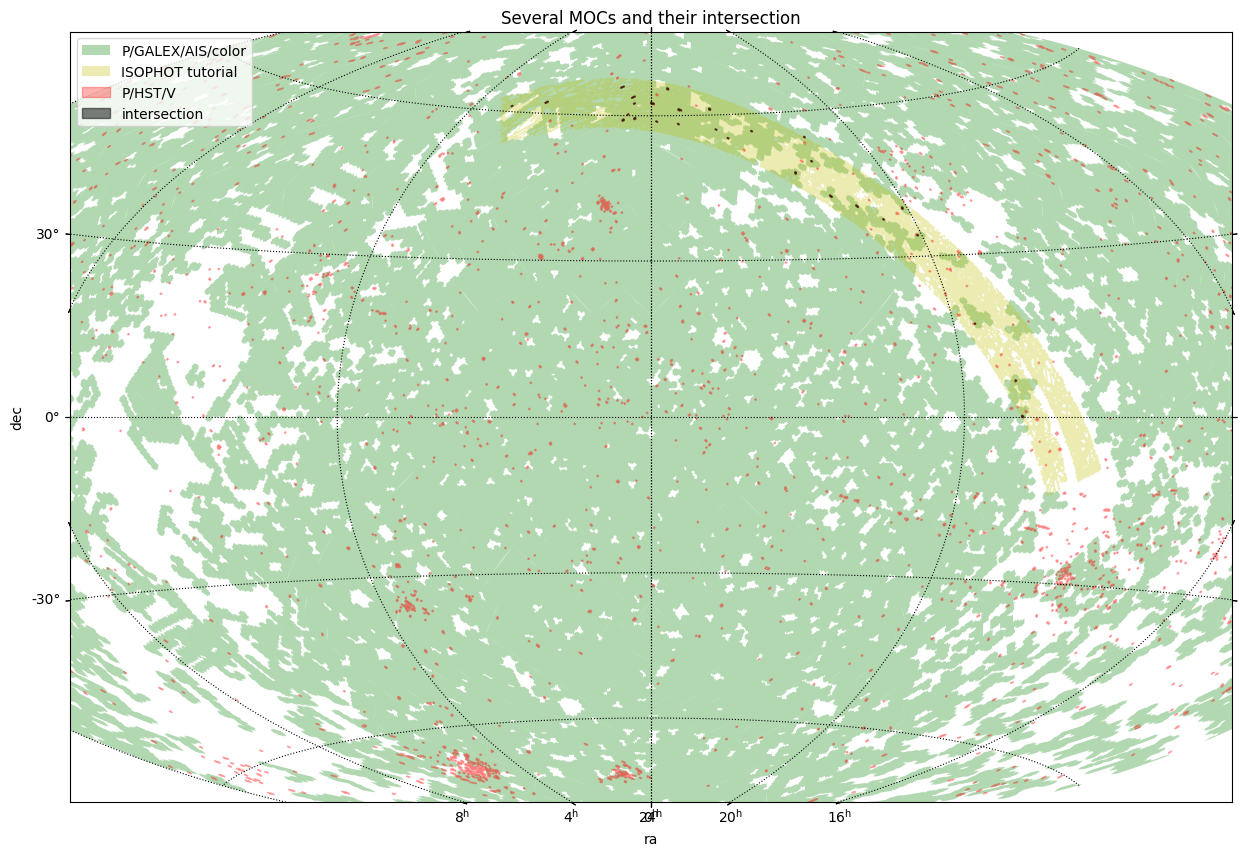

In [8]:
fig = plt.figure(111, figsize=(15, 10))
with World2ScreenMPL(
    fig,
    fov=220 * u.deg,
    center=SkyCoord(0, 0, unit="deg", frame="icrs"),
    coordsys="icrs",
    rotation=Angle(0, u.degree),
    projection="AIT",
) as wcs:
    # Create a matplotlib axe and give it a astropy.wcs.WCS-like object
    ax = fig.add_subplot(1, 1, 1, projection=wcs)

    # Fill the GALEX MOC in green with an opacity of 70%
    galex.fill(
        ax=ax,
        wcs=wcs,
        edgecolor="g",
        facecolor="g",
        linewidth=0,
        fill=True,
        alpha=0.3,
        label="P/GALEX/AIS/color",
    )

    # Fill the Isophot MOC in yellow with an opacity of 70%
    isophot.fill(
        ax=ax,
        wcs=wcs,
        edgecolor="y",
        facecolor="y",
        linewidth=0,
        fill=True,
        alpha=0.3,
        label="ISOPHOT tutorial",
    )

    # Fill the hstv MOC in red
    hstv.fill(
        ax=ax,
        wcs=wcs,
        edgecolor="r",
        facecolor="r",
        linewidth=1.0,
        fill=True,
        alpha=0.3,
        label="P/HST/V",
    )

    # Plot the intersection in black
    moc.fill(
        ax=ax,
        wcs=wcs,
        edgecolor="k",
        facecolor="k",
        linewidth=1.0,
        fill=True,
        alpha=0.5,
        label="intersection",
    )

plt.xlabel("ra")
plt.ylabel("dec")
plt.title("Several MOCs and their intersection")
plt.grid(color="black", linestyle="dotted")
plt.legend(loc="upper left")
plt.show()
plt.close()

## Finding relevant catalogues

Querying the MOCServer using `astroquery.cds` can help us knowing which vizier tables have sources in our intersection MOC. As `astroquery.cds.query_region` returns an `astropy.table.Table`, it is also possible to do some post-filtering on the large amount of tables we might receive.

In [7]:
data_cols = cds.query_region(moc)

As the returned object is an `astropy.table.Table`, one can use mask arrays to filter the table. We add constraints to only keep catalogues, with observation in the Infrared, with at least 10,000 rows.

In [8]:
mask = (
    (data_cols["obs_regime"] == "Infrared")
    & (data_cols["dataproduct_type"] == "catalog")
    & (data_cols["nb_rows"] > 10000)
)
col = data_cols[mask][
    "obs_id", "obs_title", "dataproduct_type", "cs_service_url", "nb_rows"
]
col

obs_id,obs_title,dataproduct_type,cs_service_url,nb_rows
str28,str91,object,object,float64
B/denis/denis,"The DENIS database (DENIS Consortium, 2005) (denis)",catalog,http://vizier.u-strasbg.fr/viz-bin/votable/-A?-source=B%2Fdenis%2Fdenis&,355220325.0
II/125/main,"IRAS catalogue of Point Sources, Version 2.0 (IPAC 1986) (main)",catalog,http://vizier.u-strasbg.fr/viz-bin/votable/-A?-source=II%2F125%2Fmain&,245889.0
II/126/sources,IRAS Serendipitous Survey Catalog (IPAC 1986) (sources),catalog,http://vizier.u-strasbg.fr/viz-bin/votable/-A?-source=II%2F126%2Fsources&,43886.0
II/225/catalog,"Catalog of Infrared Observations, Edition 5 (Gezari+ 1999) (catalog)",catalog,http://vizier.u-strasbg.fr/viz-bin/votable/-A?-source=II%2F225%2Fcatalog&,374653.0
II/225/names,"Catalog of Infrared Observations, Edition 5 (Gezari+ 1999) (names)",catalog,http://vizier.u-strasbg.fr/viz-bin/votable/-A?-source=II%2F225%2Fnames&,111934.0
II/225/psc,"Catalog of Infrared Observations, Edition 5 (Gezari+ 1999) (psc)",catalog,http://vizier.u-strasbg.fr/viz-bin/votable/-A?-source=II%2F225%2Fpsc&,26948.0
...,...,...,...,...
V/114/msx6_gp,MSX6C Infrared Point Source Catalog (Egan+ 2003) (msx6_gp),catalog,http://vizier.u-strasbg.fr/viz-bin/votable/-A?-source=V%2F114%2Fmsx6_gp&,431711.0
V/114/msx6_lr,MSX6C Infrared Point Source Catalog (Egan+ 2003) (msx6_lr),catalog,http://vizier.u-strasbg.fr/viz-bin/votable/-A?-source=V%2F114%2Fmsx6_lr&,75993.0


## View in Aladin Lite

To finish this tutorial, we will use `ipyaladin` to display in Aladin Lite some MOCs:

In [ ]:
import ipyaladin as ipyal

aladin = ipyal.Aladin(target="19 40 +15", fov=5)
aladin

In [ ]:
# Add the ISOPHOT and intersection MOCs to the view
aladin.add_moc_from_dict(
    isophot.serialize(format="json"),
    {
        "opacity": 0.5,
        "color": "#e6e600",
    },
)
aladin.add_moc_from_dict(
    moc.serialize(format="json"),
    {
        "opacity": 0.8,
        "color": "#FF0000",
    },
)

And we overlay sources from VizieR catalogue `V/114/msx6_s` found in the previous query.

In [ ]:
from astroquery.vizier import Vizier

v = Vizier(columns=["*", "_RAJ2000", "_DEJ2000"])
v.ROW_LIMIT = 2000
msx6 = v.get_catalogs("V/114/msx6_s")[0]
aladin.add_table(msx6)

We can also query directly a catalogue (even a very large one like 2MASS - II/246/out) for sources located inside a MOC:

In [ ]:
twomass = moc.query_vizier_table(table_id="II/246/out")

And load it in Aladin Lite

In [ ]:
aladin.add_table(twomass)